### Basic ISC

The goal of this notebook is to run a simple overall ISC (across the whole sample) in order to establish comparability with the older partly-cloudy study. 

To this end, we'll quickly reproduce the old study's basic ISC results. 

Note, however, that the study had some differences: The MRI parameters differed (TR -- hence, different lenght), the movie was possibly cut slightly differently (though that wouldn't directly impact the ISC comparison), and we had used only a 268-parcellation (Shen), whereas the current, newer data made use of a 293-region parcellation (that does, however, include the Shen-regions as regions 1-268 --- and then amends them with subcortical regions like the AAN and basal ganglia).

#### Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle
from nilearn import plotting, input_data, datasets
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
warnings.simplefilter("ignore")

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


#### Load timeseries, run basic ISC (static)

In [2]:
# load timeseries, swap axes
ts_array = np.load('../data/99_other/old_study_ts_array_shen268_regional_average_ages13-99.npy')
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)

# submit to ISC analysis
# takes about 15-20 minutes on normal machine
ISC, p, distribution = partly_phaseshift_isc(ts_data, 
                                           pairwise= False,
                                           summary_statistic = np.mean,
                                           n_shifts = 10,#00, #can reduce to speed up, better increase to 1000
                                           return_distribution=True)

ISC[np.isnan(ISC)] = 0

# Stats correction (uncomment if you computed enough n_shifts)
alpha                           = .05
q                               = multipletests(p[0, :], method='fdr_by')[1]
corrected                       = q[np.newaxis, :] < alpha
#ISC[corrected == False]         = 0

isc_result_dict                 = {}
isc_result_dict['ISC']          = ISC
isc_result_dict['p']            = p
isc_result_dict['distribution'] = distribution

#### Plot ISC results

<Figure size 1440x1080 with 0 Axes>

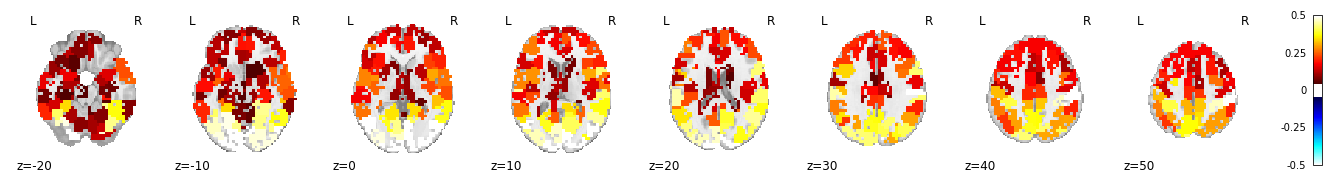

In [3]:
shen_file = '../data/02_rois_masks_maps/shen_2mm_268_parcellation.nii';

labels_masker = input_data.NiftiLabelsMasker(shen_file);
dataset = datasets.fetch_development_fmri(n_subjects = 1);
labels_masker.fit_transform(dataset.func[0]);

curr_isc = np.reshape(ISC, (268,1)).T
curr_img = labels_masker.inverse_transform(curr_isc);
plt.figure(figsize = (20,15));
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.05, 
                                   vmax         = 0.5, 
                                   draw_cross   = True,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20,  30, 40, 50],
                                   annotate     = True,);
plt.show();

In [4]:
np.save('../data/99_other/oldstudy_isc.npy', curr_isc)